First few files in the directory: ['w0001_s03_pWOZ_r01.png', 'w0002_s01_pPHR_r03.png', 'w0001_s02_pPHR_r01.png', 'w0002_s01_pPHR_r02.png', 'w0001_s03_pWOZ_r02.png']
Number of classes: 2


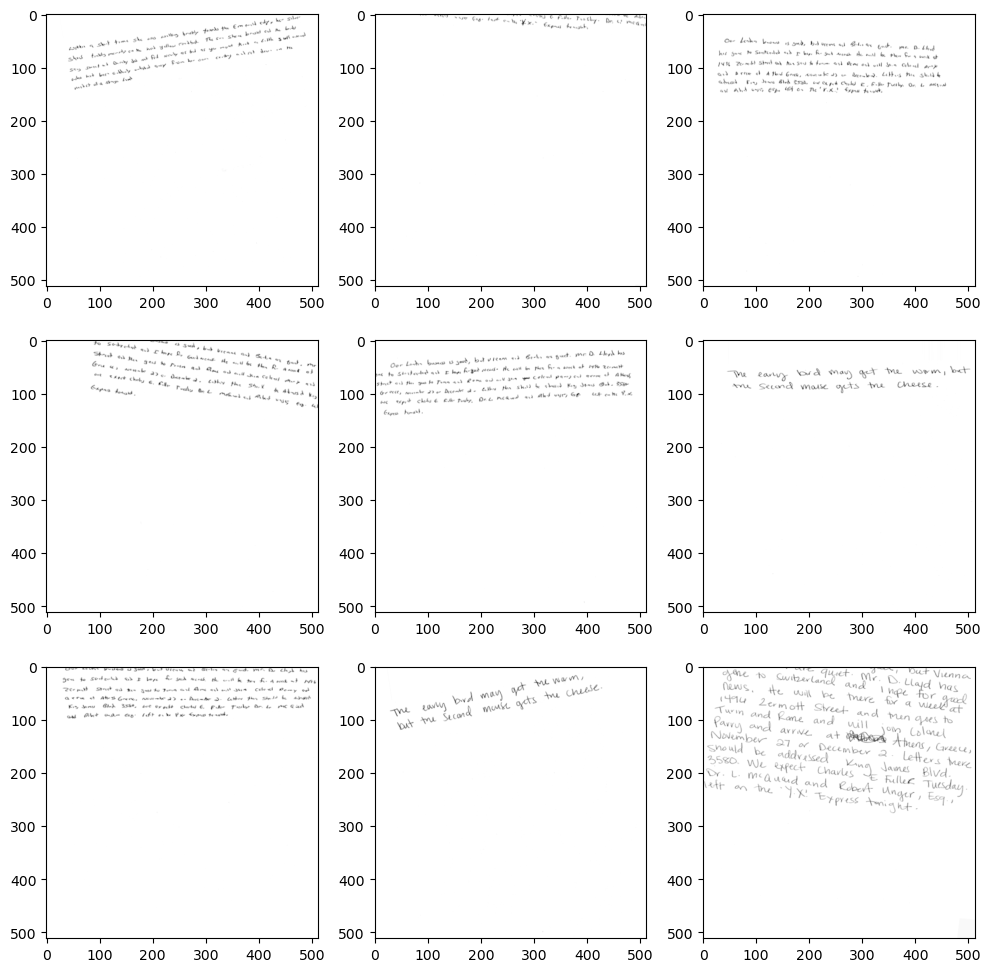

Epoch 1/50


2024-07-13 19:22:18.876543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 13s 3s/step - loss: 1.1540 - accuracy: 0.4884 - val_loss: 1.9985 - val_accuracy: 0.4545
Epoch 2/50
2/2 [==============================] - 13s 10s/step - loss: 1.5045 - accuracy: 0.4884 - val_loss: 0.7003 - val_accuracy: 0.4545
Epoch 3/50
1/2 [==============>...............] - ETA: 7s - loss: 0.7183 - accuracy: 0.5000


KeyboardInterrupt



In [3]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Define the directory where the images are located
extract_dir = "/Users/palaktiwari/Documents/Polygence/CSAFE_Handwriting_Images (1)"

# Check if the directory exists
if not os.path.exists(extract_dir):
    parent_dir = os.path.dirname(extract_dir)
    print("The directory does not exist. Here are the contents of the parent directory:")
    print(os.listdir(parent_dir))
    raise FileNotFoundError(f"The directory {extract_dir} does not exist")

# List all files in the directory
image_files = os.listdir(extract_dir)

# Print out the first few files to verify
print("First few files in the directory:", image_files[:5])

# Create a set to store unique class names
classes = set()
for file in image_files:
    class_name = file.split('_')[0]
    classes.add(class_name)

# Number of unique classes
num_classes = len(classes)
print("Number of classes:", num_classes)

# Prepare images and labels
images = []
labels = []
for file in image_files:
    image_path = os.path.join(extract_dir, file)
    image = Image.open(image_path)
    image = image.resize((512, 512))  # Resize to 512x512 pixels
    image = image.convert('L')  # Convert to grayscale
    images.append(np.array(image))
    label = file.split('_')[0]  # Use part of filename as label
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
images = images.astype('float32') / 255.0  # Normalize image data

# Encode the labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Expand dimensions of images for CNN input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Visualize some augmented images
plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
    break
plt.show()

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping with increased patience
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save('handwriting_recognition_model.h5')

# Load the saved model
loaded_model = keras.models.load_model('handwriting_recognition_model.h5')

# Function to predict and decode writer
def predict_writer(image_path, model, label_encoder):
    image = Image.open(image_path)
    image = image.resize((512, 512))
    image = image.convert('L')
    image = np.array(image).astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)
    writer = label_encoder.inverse_transform(predicted_label)
    return writer[0]

# Test the prediction
# Provide the path to a test image from your test set
# Example: test_image_path = "/path/to/test/image.png"
# Uncomment the following lines to test prediction on a specific image
# test_image_path = "/path/to/test/image.png"
# predicted_writer = predict_writer(test_image_path, loaded_model, label_encoder)
# print("Predicted Writer:", predicted_writer)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

First few files in the directory: ['w0001_s03_pWOZ_r01.png', 'w0002_s01_pPHR_r03.png', 'w0001_s02_pPHR_r01.png', 'w0002_s01_pPHR_r02.png', 'w0001_s03_pWOZ_r02.png']
Number of classes: 2


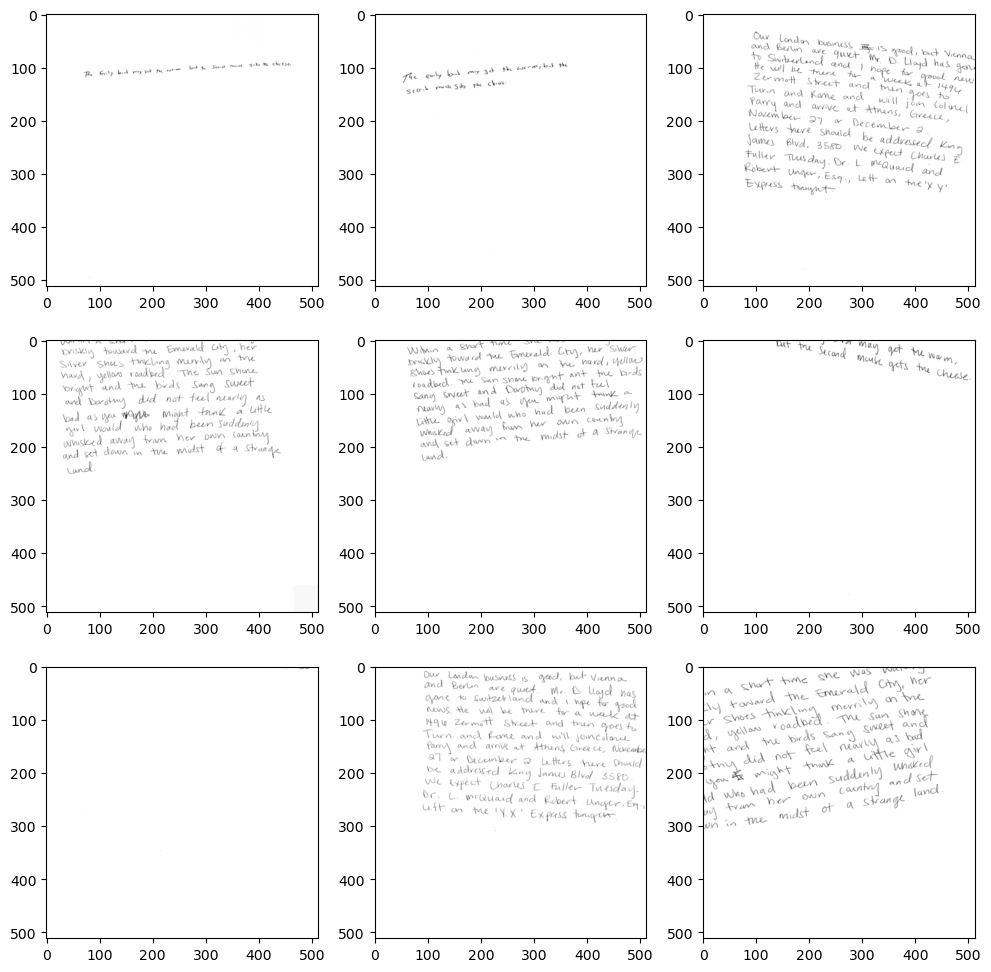

Epoch 1/50


2024-07-13 19:23:10.163696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 12s 9s/step - loss: 1.5640 - accuracy: 0.4651 - val_loss: 1.3982 - val_accuracy: 0.4545
Epoch 2/50
2/2 [==============================] - 11s 8s/step - loss: 1.1709 - accuracy: 0.5116 - val_loss: 0.6892 - val_accuracy: 0.5455
Epoch 3/50
2/2 [==============================] - 11s 3s/step - loss: 0.8632 - accuracy: 0.3953 - val_loss: 0.7934 - val_accuracy: 0.5455
Epoch 4/50
2/2 [==============================] - 10s 8s/step - loss: 0.8493 - accuracy: 0.4884 - val_loss: 0.6914 - val_accuracy: 0.5455
Epoch 5/50
2/2 [==============================] - 12s 4s/step - loss: 0.7217 - accuracy: 0.5349 - val_loss: 0.7458 - val_accuracy: 0.4545
Epoch 6/50
2/2 [==============================] - 12s 9s/step - loss: 0.7339 - accuracy: 0.6279 - val_loss: 0.7967 - val_accuracy: 0.4545
Epoch 7/50
2/2 [==============================] - 11s 9s/step - loss: 0.7322 - accuracy: 0.4651 - val_loss: 0.7267 - val_accuracy: 0.4545
Epoch 8/50
2/2 [=============================

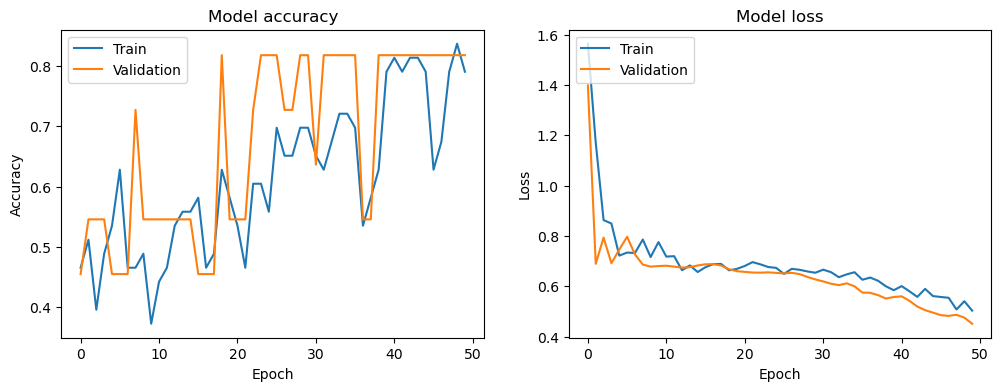

In [6]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Define the directory where the images are located
extract_dir = "/Users/palaktiwari/Documents/Polygence/CSAFE_Handwriting_Images (1)"

# Check if the directory exists
if not os.path.exists(extract_dir):
    parent_dir = os.path.dirname(extract_dir)
    print("The directory does not exist. Here are the contents of the parent directory:")
    print(os.listdir(parent_dir))
    raise FileNotFoundError(f"The directory {extract_dir} does not exist")

# List all files in the directory
image_files = os.listdir(extract_dir)

# Print out the first few files to verify
print("First few files in the directory:", image_files[:5])

# Create a set to store unique class names
classes = set()
for file in image_files:
    class_name = file.split('_')[0]
    classes.add(class_name)

# Number of unique classes
num_classes = len(classes)
print("Number of classes:", num_classes)

# Prepare images and labels
images = []
labels = []
for file in image_files:
    image_path = os.path.join(extract_dir, file)
    image = Image.open(image_path)
    image = image.resize((512, 512))  # Resize to 512x512 pixels
    image = image.convert('L')  # Convert to grayscale
    images.append(np.array(image))
    label = file.split('_')[0]  # Use part of filename as label
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)
images = images.astype('float32') / 255.0  # Normalize image data

# Encode the labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Expand dimensions of images for CNN input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Visualize some augmented images
plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
    break
plt.show()

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping with increased patience
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save('handwriting_recognition_model.h5')

# Load the saved model
loaded_model = keras.models.load_model('handwriting_recognition_model.h5')

# Function to predict and decode writer
def predict_writer(image_path, model, label_encoder):
    image = Image.open(image_path)
    image = image.resize((512, 512))
    image = image.convert('L')
    image = np.array(image).astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)
    writer = label_encoder.inverse_transform(predicted_label)
    return writer[0]

# Test the prediction
# Provide the path to a test image from your test set
# Example: test_image_path = "/path/to/test/image.png"
# Uncomment the following lines to test prediction on a specific image
# test_image_path = "/path/to/test/image.png"
# predicted_writer = predict_writer(test_image_path, loaded_model, label_encoder)
# print("Predicted Writer:", predicted_writer)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()